In [30]:
import torch
import os
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [31]:
torch.__version__

'1.12.1'

In [32]:
torch.cuda.is_available()

True

In [33]:
class Config:
    def __init__(self):
        self.ROOT_DATA_DIR="FashionMNISTDir"
        self.EPOCH =10
        self.LEARNING_RATE=0.01
        self.IMAGE_SIZE=(28,28)
        self.BATCH_SIZE=32
        self.DEVICE="cuda" if torch.cuda.is_available() else "cpu"
        print(f"This notbook is using device: {self.DEVICE}")
        self.SEED=2022

config=Config()




This notbook is using device: cuda


In [34]:
train_data=datasets.FashionMNIST(
    root=config.ROOT_DATA_DIR,
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    
)

test_data=datasets.FashionMNIST(
    root=config.ROOT_DATA_DIR,
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    
)

In [35]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [36]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [37]:
train_data.class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [38]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [39]:
given_label_map=train_data.class_to_idx
given_label_map

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [40]:
label_map={val:key for key, val in given_label_map.items() }

In [41]:
label_map

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

## Vizualize one of the samples

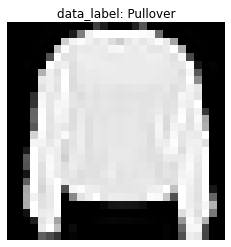

In [42]:
rnd=1
def view_sample_img(data,rnd,label_map):
    plt.imshow(train_data.data[rnd],cmap='gray')
    plt.title(f"data_label: {label_map[train_data.targets[rnd].item()]}")
    plt.axis("off")

view_sample_img(train_data,7,label_map)

## Creating the Data Loader

In [43]:
train_data_loader=DataLoader(
    dataset=train_data,
    batch_size=config.BATCH_SIZE,
    shuffle=True
    
)

test_data_loader=DataLoader(
    dataset=test_data,
    batch_size=config.BATCH_SIZE,
    shuffle=False
    
)



In [44]:
for images,labels in train_data_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 1, 28, 28])
torch.Size([32])


In [45]:
images[0].squeeze().shape, images[0].unsqueeze(dim=1).shape

(torch.Size([28, 28]), torch.Size([1, 1, 28, 28]))

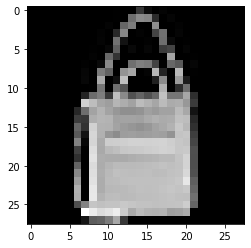

In [46]:
plt.imshow(images[0].squeeze(),cmap="gray")

In [47]:
class CNN(nn.Module):
    def __init__(self,input_channel,output_channel):
        super(CNN,self).__init__()
        self.conv_pool_01=nn.Sequential(
            nn.Conv2d(in_channels=input_channel,
            out_channels=8,
            kernel_size=5,
            stride=1,
            padding=0),

            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )
        )

        
        self.conv_pool_02=nn.Sequential(
            nn.Conv2d(in_channels=8,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=0),

            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            )

            )
        self.Flatten=nn.Flatten()
        self.FC_01=nn.Linear(in_features=16*4*4, out_features=128)
        self.FC_02=nn.Linear(in_features=128, out_features=64)
        self.FC_03=nn.Linear(in_features=64, out_features=output_channel)
        
    def forward(self,x):
        x = self.conv_pool_01(x)
        x = self.conv_pool_02(x)
        x = self.Flatten(x)
        x = self.FC_01(x)
        x = F.relu(x)
        x = self.FC_02(x)
        x = F.relu(x)    
        x = self.FC_03(x)
        return x
        

In [48]:
model=CNN(1,10)
print(model)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)


In [49]:
next(model.parameters()).is_cuda

False

In [50]:
model.to(config.DEVICE)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

In [51]:
next(model.parameters()).is_cuda

True

#### Count the no. of trainable parameters 

In [52]:
import pandas as pd
def count_params(model):
    model_params={"modules": list(),"Parameters": list()}
    total={"trainable": 0,"non_trainable":0}
    for name , parameters in model.named_parameters():
        param=parameters.numel()
        if not parameters.requires_grad:
            total["non_trainable"]+=param
            continue
        model_params['modules'].append(name)
        model_params['Parameters'].append(param)
        total['trainable']+=param
    df=pd.DataFrame(model_params)
    df=df.style.set_caption(f"Total parameters are: {total}")
    return df
count_params(model)

,modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


## Training Loop --------------------------------

In [53]:
criterion=nn.CrossEntropyLoss() #loss function
optimizer=torch.optim.Adam(model.parameters(),lr=config.LEARNING_RATE) #optimizer

In [54]:
#steps per epoch:
len(train_data_loader)

1875

In [55]:
for epoch in range(config.EPOCH):
    with tqdm(train_data_loader) as tqdm_epoch:
        for images,labels in tqdm_epoch:
            tqdm_epoch.set_description(f'Epoch {epoch+1}/{config.EPOCH}')
            # put the images on device
            images=images.to(config.DEVICE)
            labels=labels.to(config.DEVICE)

            
            #doing th forward pass
            output=model(images)
            loss=criterion(output,labels)

            #backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() #updating weights

            tqdm_epoch.set_postfix(loss=loss.item())

Epoch 1/10:   0%|          | 0/1875 [00:00<?, ?it/s]


AttributeError: module 'torch.functional' has no attribute 'relu'